## MinK++ Plotting

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [71]:
source = 'results/time_travel/'
metric = 'bleurt' 
# metric = 'rouge'
metric_1 = f"{metric}_score_for_general_completion"
metric_2 = f"{metric}_score_for_guided_completion"

In [72]:
# Function to remove outliers based on the 2.5th and 97.5th percentiles
def remove_outliers(df, column_name):
    lower_quantile = df[column_name].quantile(0.025)
    upper_quantile = df[column_name].quantile(0.975)
    return df[(df[column_name] >= lower_quantile) & (df[column_name] <= upper_quantile)]

In [73]:
dataframes = []

for subfolder in os.listdir(source):
  subfolder_path = os.path.join(source, subfolder)
  if os.path.isdir(subfolder_path):  # Check if it's a directory
    for sub_subfolder in os.listdir(subfolder_path):
      sub_subfolder_path = os.path.join(subfolder_path, sub_subfolder)
      if os.path.isdir(sub_subfolder_path):  # Check if it's a directory
        csv_file_path = os.path.join(sub_subfolder_path, "df.csv")
        if os.path.exists(csv_file_path):  # Check if df.csv exists
          # Load the CSV into a DataFrame
          df = pd.read_csv(csv_file_path)
          df = df[[metric_1, metric_2]]
          df['Dataset'] = sub_subfolder
          df['Model'] = subfolder

          df = remove_outliers(df, metric_1)
          df = remove_outliers(df, metric_2)
          
          dataframes.append(df)
          print(f"Loaded DataFrame from: {csv_file_path}")
        else:
          print(f"No df.csv found in: {sub_subfolder_path}")

Loaded DataFrame from: results/time_travel/OLMo_7b/anli/df.csv
Loaded DataFrame from: results/time_travel/OLMo_7b/scitail/df.csv
Loaded DataFrame from: results/time_travel/OLMo_7b/paws/df.csv
Loaded DataFrame from: results/time_travel/OLMo_7b/snli/df.csv
Loaded DataFrame from: results/time_travel/OLMo_7b/wnli/df.csv
Loaded DataFrame from: results/time_travel/OLMo_7b/hans/df.csv
Loaded DataFrame from: results/time_travel/OLMo_7b/mnli/df.csv
Loaded DataFrame from: results/time_travel/OLMo_7b/rte/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/anli/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/scitail/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/paws/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/snli/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/wnli/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/hans/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/mnli/df.csv
Loaded DataFrame from: results/time_travel/

In [74]:
# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Prepare the data for the violin plot
datasets = combined_df['Dataset'].unique()
models = combined_df['Model'].unique()

# Create a dictionary to hold data for each dataset and model
violin_data_left = []  # For the "general" side (left part)
violin_data_right = []  # For the "guided" side (right part)
dataset_positions = []
colors = plt.cm.tab10.colors  # Use a colormap for different model colors
model_color_map = {model: colors[i % len(colors)] for i, model in enumerate(models)}

current_position = 1
position_labels = []
position_models = []
for dataset in datasets:
    model_positions = []
    for model in models:
        subset = combined_df[(combined_df['Dataset'] == dataset) & (combined_df['Model'] == model)]
        if not subset.empty:
            # Left part: "general" score
            violin_data_left.append(subset[metric_1].values)
            # Right part: "guided" score
            violin_data_right.append(subset[metric_2].values)
            
            model_positions.append(current_position)
            position_models.append(current_position)
            current_position += 1
    # Calculate the midpoint of the model positions for the dataset
    if model_positions:
        dataset_positions.append(sum(model_positions) / len(model_positions))
        position_labels.append(dataset)
    current_position += 2

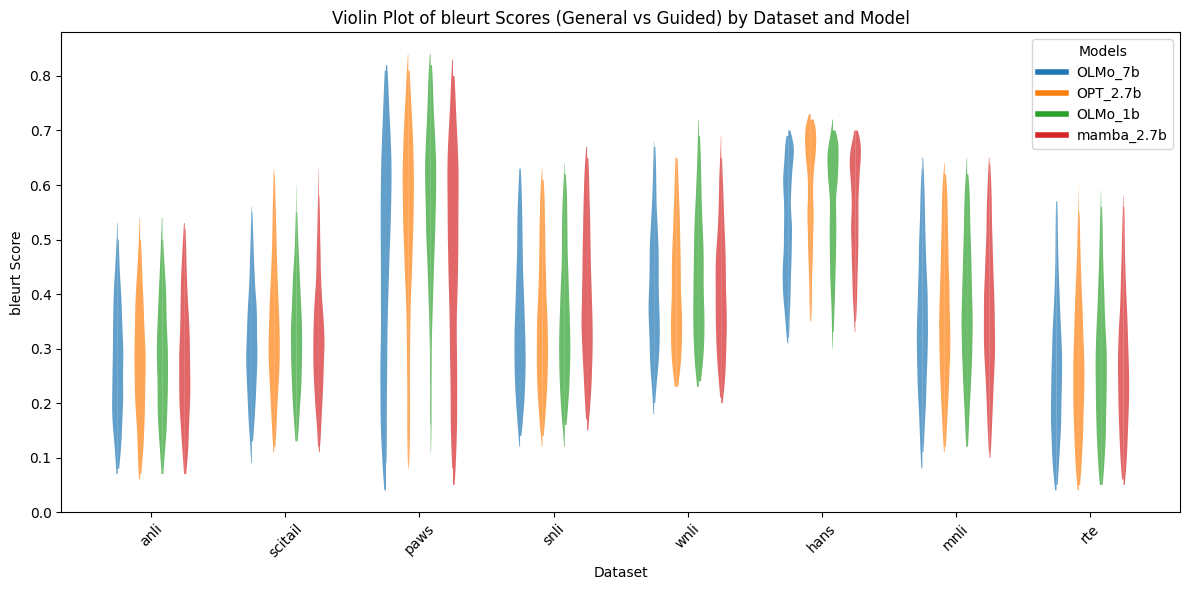

In [75]:
# Create the violin plot for both general and guided rouge scores
fig, ax = plt.subplots(figsize=(12, 6))

# Plot "general" (left) violins
violin_parts_left = ax.violinplot(violin_data_left, positions=position_models, side='low', showmeans=False, showextrema=False, showmedians=False)

# Plot "guided" (right) violins
violin_parts_right = ax.violinplot(violin_data_right, positions=position_models, side='high', showmeans=False, showextrema=False, showmedians=False)

# Add colors to the violins for the left side (general)
for i, pc in enumerate(violin_parts_left['bodies']):
    model = models[i % len(models)]  # Cycle through models
    pc.set_facecolor(model_color_map[model])
    # pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Add colors to the violins for the right side (guided)
for i, pc in enumerate(violin_parts_right['bodies']):
    model = models[i % len(models)]  # Cycle through models
    pc.set_facecolor(model_color_map[model])
    # pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Customize the X-axis
ax.set_xticks(dataset_positions)
ax.set_xticklabels(datasets, rotation=45)
ax.set_xlabel("Dataset")
ax.set_ylabel(f"{metric} Score")
ax.set_title(f"Violin Plot of {metric} Scores (General vs Guided) by Dataset and Model")

# Add a legend for the models
handles = [plt.Line2D([0], [0], color=model_color_map[model], lw=4, label=model) for model in models]
ax.legend(handles=handles, title="Models", loc="upper right")

plt.tight_layout()
plt.show()